# Tests

In [2]:
import numpy as np
import networkx as nx
from dwdynamics import ComplexDynamicsProblem, Objective # Difference a. We are using ComplexDynamicsProblem
import dimod
import matplotlib.pyplot as plt
import json
import os
import minorminer
from dwave_networkx.generators.pegasus import (get_tuple_defragmentation_fn, fragmented_edges,
    pegasus_coordinates, pegasus_graph)
from dwave.system import DWaveSampler, EmbeddingComposite
import matplotlib.pyplot as plt

In [3]:
def get_sampleset(topology, precision, simplify = True):
    # We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...
    SY = np.array([[0, -1.0j], [1.0j, 0.0]])
    PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.

    # The problem object encapsulates all the data so you don't have to pass them around
    problem = ComplexDynamicsProblem(
        hamiltonian=0.5 * np.pi * SY,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
        initial_state = PSI0,              # Starting at initial state |0>,
        times=tuple(range(3)),             # With six time points 0,1,2
        num_bits_per_var=precision                # And two bits of precision per variable
    )
    qubo = problem.qubo(objective=Objective.norm)  # Other choice would be to use Objective.hessian
    num_int = qubo.num_interactions + 1

    if simplify:
        while (num_int > qubo.num_interactions):
            num_int = qubo.num_interactions
            for key,value in qubo.quadratic.items():
                if value == 0:
                    qubo.remove_interaction(key[0],key[1])

            
    assert qubo.num_variables == problem.hamiltonian.shape[0] * len(problem.times) * problem.num_bits_per_var * 2



    DW_TOKEN = os.getenv("DW_TOKEN")  # <- Place your token here, or use DW_TOKEN env variable, or configure D-Wave libraries to use config file


    # The graph fo the problem is pretty dense, we use automatic embedding to mitigate the incompatibility with actual machine
    dw_sampler = EmbeddingComposite(DWaveSampler(solver={'topology__type': topology}))


    dw_result = dw_sampler.sample(qubo, num_reads=1000, annealing_time=200)

    dw_result.first.energy
    return dw_result



In [4]:
for i in range(0,5):
    topology = 'pegasus'
    for precision in [2]:

        dw_result = get_sampleset(topology, precision,simplify=False)
        file_name = f"../data/basic/{topology}_{precision}_{i}.json"
        with open(file_name,'w') as f:
            json.dump(dw_result.to_serializable(),f)

# Analyze

In [5]:
import os
import re
import pandas as pd
files = os.listdir('../data')

In [6]:
import dimod.sampleset

dfs = []

for topology in ['pegasus', 'zephyr']:
    for i in range(2,5):
        regex = re.compile(rf'{topology}_{i}_')

        precision_files = ([file for file in files if regex.search(file)])
        samplesets = [dimod.SampleSet.from_serializable(json.load(open(f'../data/{f}','r'))) for f in precision_files]
        samplesets = [s.to_pandas_dataframe()[['energy','num_occurrences']] for s in samplesets]
        s = pd.concat(samplesets)
        s['topology'] = topology
        s['precision'] = i
        s['energy'] = round(s['energy']+ 0.49)
        dfs.append(s)


dfs_all = pd.concat(dfs)

In [7]:
dfs_grouped =dfs_all.groupby(['topology', 'precision','energy'])['num_occurrences'].sum()
df = dfs_grouped['pegasus',4].reset_index()
df

,energy,num_occurrences
0,1.0,3
1,2.0,72
2,3.0,222
3,4.0,388
4,5.0,530
5,6.0,555
6,7.0,512
7,8.0,464
8,9.0,367
9,10.0,303


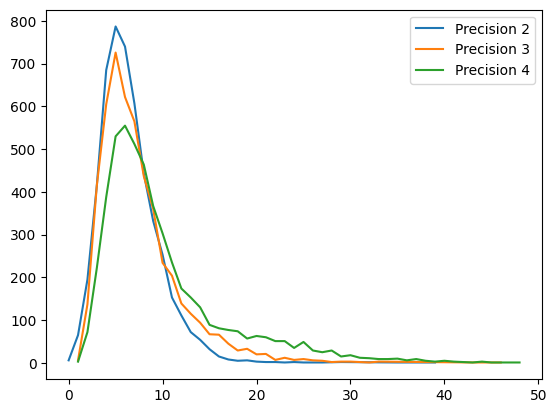

In [8]:
for p in [2,3,4]:
    df = dfs_grouped['pegasus',p].reset_index()
    plt.plot(df['energy'], df['num_occurrences'],label=f"Precision {p}")
plt.legend()


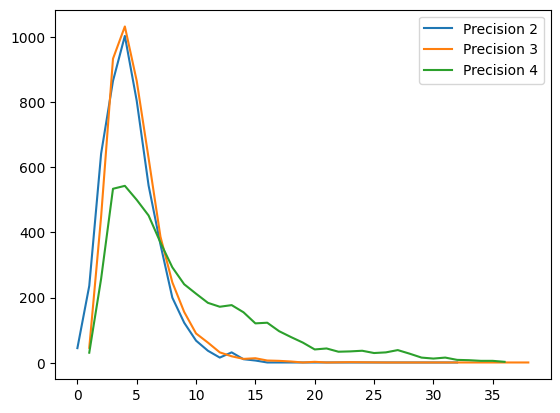

In [9]:
for p in [2,3,4]:
    df = dfs_grouped['zephyr',p].reset_index()
    plt.plot(df['energy'], df['num_occurrences'],label=f"Precision {p}")
plt.legend()


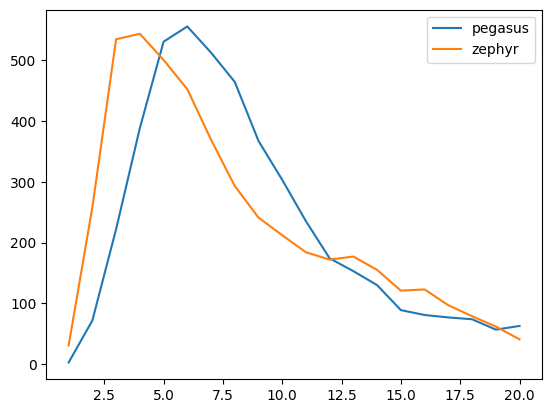

In [10]:
for topology in ['pegasus','zephyr']:
    df = dfs_grouped[topology,4].reset_index()
    df = df[df['energy']<=20]
    plt.plot(df['energy'],df['num_occurrences'],label=f"{topology}")
plt.legend()

# Simplification ?

In [11]:
for topology in ['pegasus']:
    for i in [2]:
        regex = re.compile(rf'{topology}_{i}_')

        precision_files = ([file for file in files if regex.search(file)])
        samplesets = [dimod.SampleSet.from_serializable(json.load(open(f'../data/basic/{f}','r'))) for f in precision_files]
        samplesets = [s.to_pandas_dataframe()[['energy','num_occurrences']] for s in samplesets]
        s = pd.concat(samplesets)
        s['topology'] = topology
        s['precision'] = i
        s['energy'] = round(s['energy']+ 0.49)
df_basic = s.copy()[['energy','num_occurrences']]
df_basic

,energy,num_occurrences
0,1.0,1
1,2.0,1
2,2.0,1
3,2.0,1
4,2.0,1
...,...,...
971,25.0,1
972,23.0,1
973,9.0,1
974,10.0,1


In [12]:
df_basic_grouped = df_basic[['energy','num_occurrences']].groupby('energy').sum().reset_index()
df_basic_grouped

,energy,num_occurrences
0,0.0,1
1,1.0,8
2,2.0,45
3,3.0,97
4,4.0,207
5,5.0,311
6,6.0,366
7,7.0,356
8,8.0,394
9,9.0,383


(0.0, 10.0)

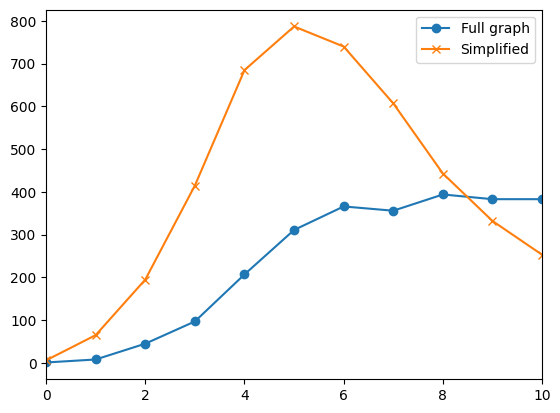

In [18]:
plt.plot(df_basic_grouped['energy'],df_basic_grouped['num_occurrences'],label="Full graph",marker='o')
plt.plot(dfs_grouped['pegasus',2],label="Simplified",marker='x')
plt.legend()
plt.xlim(0,10)

In [17]:
df_basic_grouped

,energy,num_occurrences
0,0.0,1
1,1.0,8
2,2.0,45
3,3.0,97
4,4.0,207
5,5.0,311
6,6.0,366
7,7.0,356
8,8.0,394
9,9.0,383
